In [38]:
import numpy as np
import torch
import imageio
import os

# Working with Raster Images
---

### Reading a Single Image
We will use the library, *Imageio*. *TorchVision* is also a great default for image loading.

In [39]:
img_arr = imageio.imread('../chap04/data/pug_img.jpg')
img_arr.shape

/tmp/ipykernel_26082/1683439787.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_arr = imageio.imread('../chap04/data/pug_img.jpg')


(1070, 1500, 3)

Imageio's function `imread` outputs a NumPy-like array that we will use to obtain a tensor. However, this array output is laid out as HEIGHT x WIDTH x RGB CHANNELS. PyTorch needs image data tensors to be laid out as CHANNELS x HEIGHT x WIDTH

### Changing the Image Array's Layout
We can use the PyTorch method `permute` to easily reorganize the layout of a tensor

In [40]:
img = torch.from_numpy(img_arr)
img = img.permute(2, 0, 1) #select channels, then height, then width

### Reading Multiple Images
We have 3 images of cats. Rather than creating 3 tensors corresponding to the 3 images and then using `stack` to combine them into one tensor, it's more efficient to allocate a tensor of appropriate size and fill it with the images.

In [41]:
#getting a list of the files first so I can have a parametric batch size
data_dir = '../chap04/data/cats/'
file_names = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.png']
batch_size = len(file_names)


In [42]:
#initializing the holder tensor
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8) # samples, channels, height, width

In [43]:
for i, filename in enumerate(file_names):
    img_arr = imageio.imread(os.path.join(data_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2,0,1) # the proper pytorch layout
    
    #png images will sometimes have an alpha channel. To ensure we are only grabbing the RGB channels, we do the following:
    img_t = img_t[:3]
    batch[i] = img_t # assign the image to the holder tensor

batch = batch.float() # converting the bytes to floats for the next step
batch.dtype

/tmp/ipykernel_26082/2399130317.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_arr = imageio.imread(os.path.join(data_dir, filename))


torch.float32

### Normalizing the data
NNs work best when data is normalized from 0 to 1 or from -1 to 1. The best way to do so is to compute the mean and standard deviation of the input data and scale it so that the output has zero mean and unit standard deviation across each channel.

*Note* This does not mean that we need a range of 0 to one. We can also have a *mean* of 0, and a *standard deviation* of 1.

In [44]:
n_channels = batch.shape[1] #looking at the RGB channels

for c in range(n_channels):
    mean = torch.mean(batch[:, c]) # mean of each channel for all images
    std = torch.std(batch[:, c]) # Standard deviation of each channel for all images
    batch[:, c] = (batch[:, c] - mean) / std

print(batch.mean(), batch.std())

tensor(-2.8147e-08) tensor(1.0000)


# Working with Volumetric Data
---

CT Scans map slices of the body, displaying density as intensity. For example, bone will be bright white, and soft tissue will be darker grey. <br>
<br>
Since CT scans have a single intensity channel, the channel dimension is often left out of the raw data. The raw data would be stored like : *sliceNo X Density X height X width*. 

We can use the function `unsqueeze` - [see docs.](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html) - to add the channel dimension around the density dimension, giving us a layout like: *sliceNo X channel X density X height X width*.

In [45]:
import imageio

dir_path = "../chap04/data/ct_scans/"
vol_arr = imageio.volread(dir_path, 'DICOM')
vol_arr.shape # we will see our data will have a shape (density, height, width)

Reading DICOM (examining files): 1/198 files (0.5198/198 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 99/99  (100.0%)


(99, 512, 512)

In [46]:
print(f'The initial data type is {vol_arr.dtype}')
vol = torch.from_numpy(vol_arr).float() # convert from int16 to float

vol = torch.unsqueeze(vol, 0) # Add a dimension around density (almost like graft)
vol.shape

The initial data type is int16


torch.Size([1, 99, 512, 512])

# Representating Tabular Data
---

Rectangular data is often not homogenous. For instance, you might have a column letting you know what fruit is for sale (text) and another column representing weight (a number). The first step in working with tabular data is to ***encode*** heterogeneous, real-world data into a tensor of floating-point numbers.

In [47]:
# loading the winequality.csv
import csv

wine_path = "../chap04/data/winequality.csv"
wineq_np = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1)
wineq_np

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [48]:
# checking the header row against the shape to make sure all data has been read
col_list = next(csv.reader(open(wine_path), delimiter=";"))

wineq_np.shape, col_list

((4898, 12),
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'])

In [49]:
#convert the numpy array to a PyTorch tensor:
wineq = torch.from_numpy(wineq_np)
wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

### Representing Scores
We have two options: we could treat the score as a continuous variable / as a real number and perform regression or we could treat it as a label and try to guess the label based on the chemical analysis.
<br>
In both approaches, we need to remove the score from the input data tensor so we can use the score as the ground truth without it being an input.

In [50]:
data = wineq[:, :-1] # select all columns except the last one
data, data.shape

(tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
         [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
         ...,
         [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
         [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]]),
 torch.Size([4898, 11]))

In [51]:
target = wineq[:, -1] # select the last column of all rows
target, target.shape

(tensor([6., 6., 6.,  ..., 6., 7., 6.]), torch.Size([4898]))

If we want to treat the `target` tensor as a simple integer vector of scores (continuous), we can do this:

In [52]:
cont_target = wineq[:, -1].long()
cont_target, cont_target.dtype

(tensor([6, 6, 6,  ..., 6, 7, 6]), torch.int64)

### One-Hot Encoding
We can also use *one-hot encoding*. Each score out of 10, would be encoded as a vector with a dimension of 10, where all attributes are zero, except for the scored mapped as an index, which is one. For example: <br>
<br>
$A~score~of~5~out~of~10 = (0, 0, 0, 0, 1, 0, 0, 0, 0, 0)$

*One-hot encoding* is appropriate where there is no implied ordering or distance or, where there are no fractional values between scores. See *Continuous, Ordinal, and Categorical Values - pg. 80*.

In [53]:
target_onehot = torch.zeros(target.shape[0], 10) #create a tensor with data length rows and 10 columns

In [54]:
target_onehot.scatter_(1, target.long().unsqueeze(1), 1.0)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Remember, since the method `scatter_` has the trailing underscore, it modifies the tensor in place. <br>


As per the [docs](https://pytorch.org/docs/stable/generated/torch.Tensor.scatter_.html#torch.Tensor.scatter_), the parameters for `scatter_` are: 
* **dim (int)** – the axis along which to index

* **index (LongTensor)** – the indices of elements to scatter, can be either empty or of the same dimensionality as src. When empty, the operation returns self unchanged.

* **src (Tensor or float)** – the source element(s) to scatter.

So for the above, we are saying, *for each row (axis 1), at the index specified by the last column of `target`, insert a `1.0`

### Normalizing the Wine Data

In [55]:
data_mean = torch.mean(data, dim=0) # find the mean for each column
data_mean

tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
        1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01])

The `dim=0` confused me. The 0th dimension is the row, so wouldn't the above take the mean per each row? Paraphrase from [this article](https://towardsdatascience.com/understanding-dimensions-in-pytorch-6edf9972d3be):<br><br>
*The way to understand the “dim” of pyTorch operations is that it collapses the specified axis. So when it collapses the axis 0 (the row), it becomes just one row (it takes the mean column-wise).*

In [56]:
data_var = torch.var(data, dim=0) # calculate the variance for each column
data_var

tensor([7.1211e-01, 1.0160e-02, 1.4646e-02, 2.5726e+01, 4.7733e-04, 2.8924e+02,
        1.8061e+03, 8.9455e-06, 2.2801e-02, 1.3025e-02, 1.5144e+00])

In [57]:
# normalizing the data
data_normalized = (data - data_mean) / torch.sqrt(data_var)
data_normalized

tensor([[ 1.7208e-01, -8.1761e-02,  2.1326e-01,  ..., -1.2468e+00,
         -3.4915e-01, -1.3930e+00],
        [-6.5743e-01,  2.1587e-01,  4.7996e-02,  ...,  7.3995e-01,
          1.3422e-03, -8.2419e-01],
        [ 1.4756e+00,  1.7450e-02,  5.4378e-01,  ...,  4.7505e-01,
         -4.3677e-01, -3.3663e-01],
        ...,
        [-4.2043e-01, -3.7940e-01, -1.1915e+00,  ..., -1.3130e+00,
         -2.6153e-01, -9.0545e-01],
        [-1.6054e+00,  1.1666e-01, -2.8253e-01,  ...,  1.0049e+00,
         -9.6251e-01,  1.8574e+00],
        [-1.0129e+00, -6.7703e-01,  3.7852e-01,  ...,  4.7505e-01,
         -1.4882e+00,  1.0448e+00]])

In [58]:
# remember, normalized data has a mean of 0 and a standard deviation of 1
data_normalized.mean(), data_normalized.std()

(tensor(1.2235e-07), tensor(0.9999))

### Finding Thresholds
Even without a neural network, we can start to look into the data.

In [59]:
bad_indexes = target <= 3 # a boolean filter where scores lower than 3 are true
bad_indexes.shape, bad_indexes.dtype, bad_indexes.sum() # the sum will let us know how many bad wines there are

(torch.Size([4898]), torch.bool, tensor(20))

In [60]:
# we can now apply the boolean mask to the data to return only the info. for the bad wines
bad_data = data[bad_indexes]
bad_data.shape

torch.Size([20, 11])

In [61]:
# sorting the data into bad, mid, and good - we can shorthand the above steps
bad_data = data[target <= 3]
mid_data = data[(target > 3) & (target <7)]
good_data = data[target >= 7]

#getting the mean value for the good, the bad, and the mid
bad_mean = torch.mean(bad_data, dim=0)
mid_mean = torch.mean(mid_data, dim=0)
good_mean = torch.mean(good_data, dim=0)

#printing out the mean for each chemical property
print('{:2} {:25} {:8} {:7} {:10}'.format(" ", "property", "bad", "mid", "good"))
print('{:2} {:25} {:8} {:7} {:10}'.format(" ", "--------------", "---", "---", "----"))
for i, args in enumerate(zip(col_list, bad_mean, mid_mean, good_mean)):
    print('{:2} {:20} {:8.2f} {:8.2f} {:8.2f}'.format(i, *args))

   property                  bad      mid     good      
   --------------            ---      ---     ----      
 0 fixed acidity            7.60     6.89     6.73
 1 volatile acidity         0.33     0.28     0.27
 2 citric acid              0.34     0.34     0.33
 3 residual sugar           6.39     6.71     5.26
 4 chlorides                0.05     0.05     0.04
 5 free sulfur dioxide     53.33    35.42    34.55
 6 total sulfur dioxide   170.60   141.83   125.25
 7 density                  0.99     0.99     0.99
 8 pH                       3.19     3.18     3.22
 9 sulphates                0.47     0.49     0.50
10 alcohol                 10.34    10.26    11.42


From the above it looks like *total sulfur dioxide* plays a large role in determining whats a good and whats a bad wine. We can use the threshold of the mid-mean, 141.83 to naively predict good wines.

In [62]:
sulfur_threshold = 141.83
total_sulfur_data = data[:, 6] # total sulfur dioxide column for every row

# torch.lt() computes input < other element wise
predicted_indices = torch.lt(total_sulfur_data, sulfur_threshold)

predicted_indices.shape, predicted_indices.dtype, predicted_indices.sum()

(torch.Size([4898]), torch.bool, tensor(2727))

The above test predicts that the data set contains 4898 good wines, when in reality there are about 500 more. NNs and basic machine learning techniques could improve this prediction a lot!

---
# When to Categorize
Usually, you will treat your data as categorical and drop the the ordering, or continuous (but that introduces an arbitrary notion of distance). See below for general guidelines.

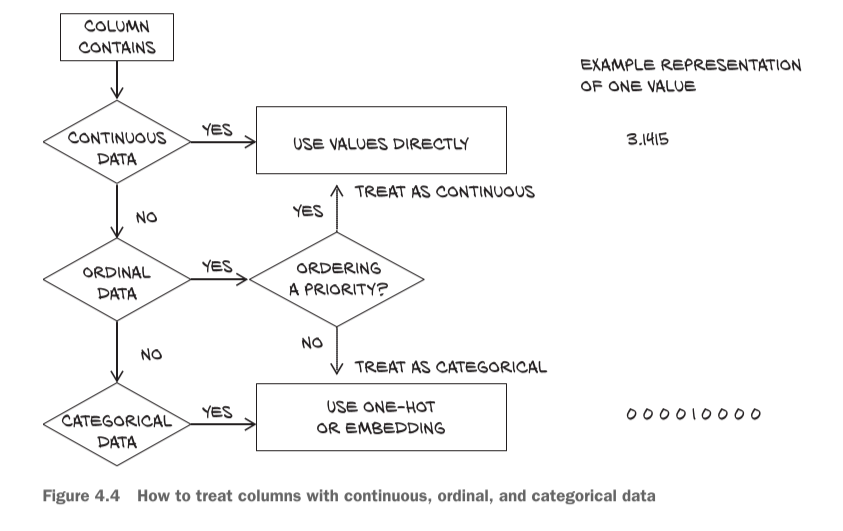

# Working with time series data
We will be working with a hourly counting of bike-share rentals. Found [here](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset.)

### Adding a time dimension - importing the data
Our data is organized by row per hour. We want to re-organize this to have one axis that increases per day, a second axis that represents the hour per day, and a third axis that contains the columns of data such as weather, temperature, etc.

In [63]:
# loading the data
bikes_np = np.loadtxt("data/bike_share/hours.csv",
                      dtype=np.float32,
                      delimiter=',',
                      skiprows=1,
                      converters={1: lambda x: float(x[8:10])})
                    #  last argument lambda converts date strings to nums corresponding to day of month in column 1

bikes = torch.from_numpy(bikes_np)
bikes

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.0000e+00, 1.3000e+01,
         1.6000e+01],
        [2.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.0000e+00, 3.2000e+01,
         4.0000e+01],
        [3.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.0000e+00, 2.7000e+01,
         3.2000e+01],
        ...,
        [1.7377e+04, 3.1000e+01, 1.0000e+00,  ..., 7.0000e+00, 8.3000e+01,
         9.0000e+01],
        [1.7378e+04, 3.1000e+01, 1.0000e+00,  ..., 1.3000e+01, 4.8000e+01,
         6.1000e+01],
        [1.7379e+04, 3.1000e+01, 1.0000e+00,  ..., 1.2000e+01, 3.7000e+01,
         4.9000e+01]])

We are going to batch our data into 24 hour sections, let's see what our data initially looks like in shape and stride.

In [64]:
bikes.shape, bikes.stride()

(torch.Size([17520, 17]), (17, 1))

In [65]:
# reshaping the data into 24 hour chunks
daily_bikes = bikes.view(-1, 24, bikes.shape[1])
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 24, 17]), (408, 17, 1))

For the above we can create a *view* of the pT *storage*. We can effectively create a new tensor for zero computational cost! <br><br>
When you use a `-1` in the shape input of `tensor.view(<shape>)`, tF treats it as a placeholder. We are essentially saying, create a tensor of 17 columns, in 24 rows, in however many chunks result from that organization.

We want to get a tensor shape of N x C x L where:
* N sequences of 24 hours (AKA the days)
* C channels for our data (AKA the data variables)
* L hours per day

In [66]:
#transposing dimensions 1 and 2
daily_bikes = daily_bikes.transpose(1, 2)
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 17, 24]), (408, 1, 17))

### Getting the data ready for training
The *weather situation* variable is ordinal. It has four levels (1 for good weather, ranging to 4 for bad weather). If we ddecided to treat this variable as categorical, we would on-hot-encode this vector and then concatenate the columns with the dataset.<br>
We will start by looking just at the first day to more easily render our data.

In [67]:
#we're back to using the data not organized by day so we can do a simple slice for the first 24 hours
first_day = bikes[:24].long()
first_day.shape

torch.Size([24, 17])

In [68]:
weather_onehot = torch.zeros(first_day.shape[0], 4) #create 24 rows of 4 0s vectors

first_day[:, 9] # check the weather score for all the first 24 hours

tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2])

In [69]:
# scatter ones into our weather_onehot matrix
#use unsqueeze to put each weather value into it's own dimension to match data
weather_onehot.scatter_(
    dim=1,
    index=first_day[:, 9].unsqueeze(1).long() - 1, #decrease val by 1 to translate 1->4 to 0 based indices
    value=1.0)

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])

In [70]:
#concatenate the one_hot matrix to the original dataset
concat = torch.cat((bikes[:24], weather_onehot), 1)
concat.shape
# in the above, you can see we are concatinating the first 24 hours of the bikes data set with the weather_onehot
# the second argument, 1, is the dimension over which the tensors are concatenated. ie. concatenated along the row dim.

torch.Size([24, 21])

### Concatenating the One-hot weather data to our reshaped daily-bikes tensor

In [71]:
# create zeros tensor shaped by day sample X 4 zeros X 24 hours
# corresponds to our daily_bikes shape of: day sample X 17 channels X 24 hours (N,C,L)
daily_onehot = torch.zeros(daily_bikes.shape[0], 4, daily_bikes.shape[2])
daily_onehot.shape

torch.Size([730, 4, 24])

In [72]:
#then we scatter the one-hot encoding into the tensor in the C dimension
daily_onehot.scatter_(
    1, #dimension
    daily_bikes[:,9,:].long().unsqueeze(1) - 1, #the index of the scatter. In this case the rank -1 -> index
    1.0) # the value we want to scatter in

daily_onehot[0,:,0], daily_onehot[-1, :, -1] #checking the one-hot encoding for the first and last moments

(tensor([1., 0., 0., 0.]), tensor([1., 0., 0., 0.]))

In [73]:
# concatenate along the C dimension (1)
daily_bikes = torch.cat((daily_bikes, daily_onehot), dim=1)
daily_bikes.shape # we can see the size of 21 in C, so the concatenation gave us the result we expect

torch.Size([730, 21, 24])

### Rescaling Variables in the daily bike data
There are two ways we could scale the 'temp' column.
* remap their value to a range [0,1]
* subtract the mean and divide by the std dev.

In [74]:
# remapping temperature values to range [0,1]
temp = daily_bikes[:, 10, :]
temp_min = torch.min(temp)
temp_max = torch.max(temp)

bikes_remap = daily_bikes.clone() # remember to clone to avoid side-effects

bikes_remap[:, 10, :] = ((daily_bikes[:, 10, :] - temp_min) / (temp_max - temp_min))

In [75]:
# subtracting the mean and dividing by std. deviation
temp = daily_bikes[:, 10, :]

bikes_mean_dev = daily_bikes.clone()
bikes_mean_dev[:, 10, :] = ((daily_bikes[:, 10, :] - torch.mean(temp)) / torch.std(temp))